# MNIST Dataset ML

This dataset contains images of 10 handwritten digits as 28 x 28 images. The goal is to build a classifier that can distinguish between these 10 digits.

## Imports

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow_datasets import load, show_examples

## Loading the Dataset

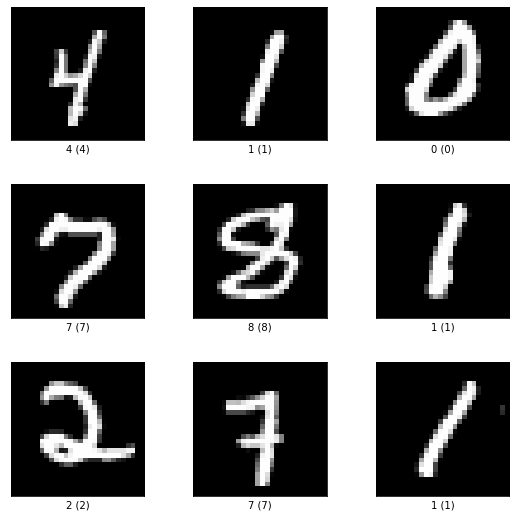

In [3]:
# Loading data
(train_ds, test_ds), ds_info = load('mnist', as_supervised=True, split=['train', 'test'], with_info=True)
fig = show_examples(train_ds, ds_info)

## Function to test if a model is better than our saved model

We just use the accuracy on the test dataset for this function for convenience, this should probably be done with a separate dataset.

In [4]:
def save_best_model(model, model_type, test_ds):
    '''
    model is expected to be a newly trained model
    model_type is expected to a string denoting the type of model (i.e. FFNN or CNN)
    '''
    try:
        saved_model = tf.keras.models.load_model(model_type)
    except:
        saved_model = None

    if saved_model:
        saved_model_metrics = saved_model.evaluate(test_ds, return_dict=True)
        new_model_metrics = model.evaluate(test_ds, return_dict=True)
        if new_model_metrics['sparse_categorical_accuracy'] > saved_model_metrics['sparse_categorical_accuracy']:
            model.save(model_type)
    else:
        model.save(model_type)

## Feed Forward Neural Network

### Processing the Dataset

In [5]:
def normalize_image(image, label):
    return tf.cast(image, tf.float32)/255, label

# Preparing training data
ffnn_train_ds = train_ds.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)
ffnn_train_ds = ffnn_train_ds.cache()
ffnn_train_ds = ffnn_train_ds.shuffle(ds_info.splits['train'].num_examples)
ffnn_train_ds = ffnn_train_ds.batch(128)
ffnn_train_ds = ffnn_train_ds.prefetch(tf.data.experimental.AUTOTUNE)

# Preparing testing data
ffnn_test_ds = test_ds.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)
ffnn_test_ds = ffnn_test_ds.cache()
ffnn_test_ds = ffnn_test_ds.batch(128)
ffnn_test_ds = ffnn_test_ds.prefetch(tf.data.experimental.AUTOTUNE)

### Building the Model

In [6]:
ffnn_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])
ffnn_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    optimizer=tf.keras.optimizers.Adam()
)
ffnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


### Training the Model

In [7]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=2)
ffnn_history = ffnn_model.fit(
    ffnn_train_ds,
    callbacks=[early_stopping_callback],
    epochs=100,
    validation_data=ffnn_test_ds
)

Epoch 1/100
469/469 [==============================] - 3s 2ms/step - loss: 0.3487 - sparse_categorical_accuracy: 0.9023 - val_loss: 0.1952 - val_sparse_categorical_accuracy: 0.9446
Epoch 2/100
469/469 [==============================] - 1s 2ms/step - loss: 0.1605 - sparse_categorical_accuracy: 0.9544 - val_loss: 0.1423 - val_sparse_categorical_accuracy: 0.9578
Epoch 3/100
469/469 [==============================] - 1s 2ms/step - loss: 0.1164 - sparse_categorical_accuracy: 0.9668 - val_loss: 0.1126 - val_sparse_categorical_accuracy: 0.9663
Epoch 4/100
469/469 [==============================] - 1s 2ms/step - loss: 0.0913 - sparse_categorical_accuracy: 0.9737 - val_loss: 0.1038 - val_sparse_categorical_accuracy: 0.9695
Epoch 5/100
469/469 [==============================] - 1s 2ms/step - loss: 0.0740 - sparse_categorical_accuracy: 0.9783 - val_loss: 0.0920 - val_sparse_categorical_accuracy: 0.9724
Epoch 6/100
469/469 [==============================] - 1s 2ms/step - loss: 0.0618 - sparse_cate

### Plotting the Results

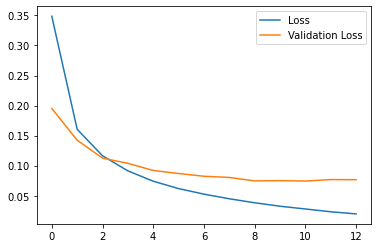

In [8]:
plt.figure()
plt.plot(ffnn_history.history['loss'], label='Loss')
plt.plot(ffnn_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


### Saving the Best Feed-Forward Model

In [9]:
save_best_model(ffnn_model, 'FFNN', ffnn_test_ds)

79/79 [==============================] - 0s 1ms/step - loss: 0.0766 - sparse_categorical_accuracy: 0.9762


## Convolutional Neural Network

### Processing the Dataset

In [10]:
def cnn_normalize_image(image, label):
    image = tf.cast(image, tf.float32)/255
    image = tf.expand_dims(image, 3) 
    return image, label

# Preparing training data
cnn_train_ds = train_ds.map(cnn_normalize_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
cnn_train_ds = cnn_train_ds.cache()
cnn_train_ds = cnn_train_ds.shuffle(ds_info.splits['train'].num_examples)
cnn_train_ds = cnn_train_ds.batch(128)
cnn_train_ds = cnn_train_ds.prefetch(tf.data.experimental.AUTOTUNE)

# Preparing testing data
cnn_test_ds = test_ds.map(cnn_normalize_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_ds = cnn_test_ds.cache()
cnn_test_ds = cnn_test_ds.batch(128)
cnn_test_ds = cnn_test_ds.prefetch(tf.data.experimental.AUTOTUNE)

### Buliding the Model

In [11]:
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 4, activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(32, 4, activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])
cnn_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    optimizer=tf.keras.optimizers.Adam(0.0005)
)
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 25, 25, 32)        544       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 32)          16416     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

### Training the Model

In [12]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_sparse_categorical_accuracy',
    mode='max',
    patience=3,
    restore_best_weights=True
)
cnn_history = cnn_model.fit(
    cnn_train_ds,
    callbacks=[early_stopping_callback],
    epochs=100,
    validation_data=cnn_test_ds
)

Epoch 1/100
469/469 [==============================] - 5s 4ms/step - loss: 0.3287 - sparse_categorical_accuracy: 0.9082 - val_loss: 0.1010 - val_sparse_categorical_accuracy: 0.9697
Epoch 2/100
469/469 [==============================] - 2s 4ms/step - loss: 0.0891 - sparse_categorical_accuracy: 0.9731 - val_loss: 0.0657 - val_sparse_categorical_accuracy: 0.9801
Epoch 3/100
469/469 [==============================] - 2s 4ms/step - loss: 0.0644 - sparse_categorical_accuracy: 0.9806 - val_loss: 0.0494 - val_sparse_categorical_accuracy: 0.9845
Epoch 4/100
469/469 [==============================] - 2s 4ms/step - loss: 0.0513 - sparse_categorical_accuracy: 0.9844 - val_loss: 0.0417 - val_sparse_categorical_accuracy: 0.9877
Epoch 5/100
469/469 [==============================] - 2s 4ms/step - loss: 0.0422 - sparse_categorical_accuracy: 0.9873 - val_loss: 0.0412 - val_sparse_categorical_accuracy: 0.9872
Epoch 6/100
469/469 [==============================] - 2s 4ms/step - loss: 0.0360 - sparse_cate

### Plotting the Training Results

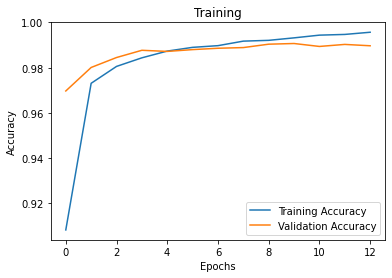

In [15]:
plt.figure()
plt.plot(cnn_history.history['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(cnn_history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

### Saving the Best CNN Model

In [14]:
save_best_model(cnn_model, 'CNN', cnn_test_ds)

79/79 [==============================] - 0s 2ms/step - loss: 0.0277 - sparse_categorical_accuracy: 0.9907


As can be seen above, the best model currently achieves 99.35% accuracy on the validation set